# Genre-Based Link Prediction

This notebook performs link prediction with genre similarity on the Discogs collaboration data. This notebook uses shared musical genres instead of the structural features.

Our hypothesis is that artists who share similar genres are more likely to collaborate.

## Imports and Loading Data

In [2]:
# imports

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score

artists = pd.read_parquet('../data/final_data_processed/discogs_artists.parquet')

edges = pd.read_parquet('../data/final_data_processed/discogs_edges.parquet')

artists_genres = pd.read_parquet('../data/final_data_processed/discogs_artists_and_genres.parquet')
print(f"\nSample genres: {artists_genres.head(3)}")
print(f"Artists with genres: {artists_genres.shape}")

print(f"Artists: {artists.shape}")
print(f"Edges: {edges.shape}")


Sample genres:   discogs_artist_id        genres
0           9134149  [Electronic]
1            403139     [Hip Hop]
2           1983365        [Jazz]
Artists with genres: (1045947, 2)
Artists: (1045947, 1)
Edges: (5673764, 3)


## Sorting Data and splitting

In [3]:
edges_sorted = edges.sort_values(by='release_year')
edges_sorted[:10]


,source_id,target_id,release_year
684582,732692,149701,1897
5041494,1103193,847630,1897
1917426,327547,847635,1897
1936777,327547,847635,1897
3523093,1402460,3140943,1897
684644,732763,698101,1897
4649316,1103193,732768,1898
684605,327547,1103198,1898
217317,732692,149701,1898
4434405,230140,499047,1898


### Era-based Split

Here is something we noticed, the data starts from 1897, if we do just one single split on the data, then it does not make any sense of whatever prediction we will get, because music has seen such a change in eras, and also artists are not even the same in these eras. 

What we are going to do to tackle this is we have our edges sorted chronologically, so we will divide our entire Discogs dataset into different musical eras. This way, we preserve the genre ecosystems, the change in artists, the technology and recording environments, and actually get predictions that are better explainable.

It will also help us analyze and understand how collaboration changed over years, which will make our entire analysis even more insightful.

This it the division we will follow:
- Era 1: Early Recording (1897 - 1945)
- Era 2: Post-WWII / Early Rock (1946 - 1965)
- Era 3: Classic Rock / Studio Revolution (1966 - 1982)
- Era 4: MTV and Digital Sampling (1983 - 1999)
- Era 5: The Internet / Streaming Era (2000 - Present)

For each era, we will:
- Filter the edges inside the year range
- Recompute the artists set (all unqiue IDs appearing in that era)
- Store each era as its own DataFram for later train/test splitting

This way, we can run independent link prediction models inside each era.

In [4]:
# Note: Now, based on earlier divisions, let us create our 5 data splits

# Note: For each era, we will first extract the edges from edges_sorted for the relevant release years, following
# which we will build the era's artists df using the unique() source_id and target_ids of those edges

# Note: Era 1
era1_edges = edges_sorted[(edges_sorted['release_year'] >= 1897) & (edges_sorted['release_year'] <= 1945)]

era1_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era1_edges.source_id, era1_edges.target_id]))})
print('Era 1')
print(len(era1_edges), len(era1_artists))

# Note: Era 2
era2_edges = edges_sorted[(edges_sorted['release_year'] >= 1946) & (edges_sorted['release_year'] <= 1965)]

era2_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era2_edges.source_id, era2_edges.target_id]))})
print('Era 2')
print(len(era2_edges), len(era2_artists))

# Note: Era 3
era3_edges = edges_sorted[(edges_sorted['release_year'] >= 1966) & (edges_sorted['release_year'] <= 1982)]

era3_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era3_edges.source_id, era3_edges.target_id]))})
print('Era 3')
print(len(era3_edges), len(era3_artists))

# Note: Era 4
era4_edges = edges_sorted[(edges_sorted['release_year'] >= 1983) & (edges_sorted['release_year'] <= 2000)]

era4_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era4_edges.source_id, era4_edges.target_id]))})
print('Era 4')
print(len(era4_edges), len(era4_artists))

# Note: Era 5
era5_edges = edges_sorted[(edges_sorted['release_year'] >= 2000) & (edges_sorted['release_year'] <= 2025)]

era5_artists = pd.DataFrame({'discogs_artist_id': pd.unique(pd.concat([era5_edges.source_id, era5_edges.target_id]))})
print('Era 5')
print(len(era5_edges), len(era5_artists))


Era 1
75692 20498
Era 2
649017 73293
Era 3
1153888 152055
Era 4
1542239 240600
Era 5
2338167 620672


## Train/Test Split for Each Era

In this bit, we will get the train/test splits for each musical era, and because we are doing a time based chronological split, we will follow a temporal link prediction methods (meaning we cannot use future collaborations to predict past ones), which will be as follows:

1. We will sort all the edges by the release_year
2. We will select a cutoff year for each era
3. All collaborations before or equal to the cut off year go into the train graph, and the latter into the test graph
4. Only the test edges where both nodes already exist in the train graph are kept

In [5]:
# Note: We will be using a function to get the cutoff year
def compute_cutoff(df, pct=0.8):
    years = df['release_year'].sort_values().unique()
    return years[int(len(years) * pct)]

# Note: Now just run it on the diff era edges we have
cut1 = compute_cutoff(era1_edges)
cut2 = compute_cutoff(era2_edges)
cut3 = compute_cutoff(era3_edges)
cut4 = compute_cutoff(era4_edges)
cut5 = compute_cutoff(era5_edges)

cut1, cut2, cut3, cut4, cut5

(np.int64(1936),
 np.int64(1962),
 np.int64(1979),
 np.int64(1997),
 np.int64(2020))

In [6]:
# Note: Now that we have our 3 cuts, we will implement that to get our train, test data for all 5 eras:

# Era 1 train/test split
era1_train = era1_edges[era1_edges['release_year'] <= cut1]
era1_test  = era1_edges[era1_edges['release_year'] > cut1]
print(f'Era 1: {len(era1_train), len(era1_test)}')

# Era 2 train/test split

era2_train = era2_edges[era2_edges['release_year'] <= cut2]
era2_test  = era2_edges[era2_edges['release_year'] > cut2]
print(f'Era 2: {len(era2_train), len(era2_test)}')

# Era 3 train/test split

era3_train = era3_edges[era3_edges['release_year'] <= cut3]
era3_test  = era3_edges[era3_edges['release_year'] > cut3]
print(f'Era 3: {len(era3_train), len(era3_test)}')

# Era 4 train/test split

era4_train = era4_edges[era4_edges['release_year'] <= cut4]
era4_test  = era4_edges[era4_edges['release_year'] > cut4]
print(f'Era 4: {len(era4_train), len(era4_test)}')

# Era 5 train/test split

era5_train = era5_edges[era5_edges['release_year'] <= cut5]
era5_test  = era5_edges[era5_edges['release_year'] > cut5]
print(f'Era 5: {len(era5_train), len(era5_test)}')

Era 1: (52269, 23423)
Era 2: (476093, 172924)
Era 3: (930641, 223247)
Era 4: (1285587, 256652)
Era 5: (1940401, 397766)


### Ensure Valid Test Edges

There is one thing though, a test edge (u,v) is only meaningful if both the nodes are in the train graph, otherwise the model will not be able to predict it using structural information, aka just looking at the graph data, of the train data. Therefore, we will filter the test sets to only include edges wehre: source_id is in train_nodes, target_id is in test_nodes.

A more explanable way to put this is, if we think about a cut off year, then the model only knows the artists up until that point, then if new artists come into play after that year then the model could not possible predict the artist's future collaborations because they never existed in the graph until after the test period began. Same idea for artists whose careers end.

In [7]:
# Note: We will use a function to help us filter as we discribed earlier
def filter_artist_only_after_test(train_edges, test_edges):
    train_nodes = set(train_edges['source_id']).union(train_edges['target_id'])
    return test_edges[(test_edges['source_id'].isin(train_nodes)) & (test_edges['target_id'].isin(train_nodes))] 

# Note: Now we just apply this filtering to each era
era1_test = filter_artist_only_after_test(era1_train, era1_test)
era2_test = filter_artist_only_after_test(era2_train, era2_test)
era3_test = filter_artist_only_after_test(era3_train, era3_test)
era4_test = filter_artist_only_after_test(era4_train, era4_test)
era5_test = filter_artist_only_after_test(era5_train, era5_test)

# Note: Now let us just print the final lengths after all processing before moving on to making the actual graphs
print("Era 1:", len(era1_train), len(era1_test))
print("Era 2:", len(era2_train), len(era2_test))
print("Era 3:", len(era3_train), len(era3_test))
print("Era 4:", len(era4_train), len(era4_test))
print("Era 5:", len(era5_train), len(era5_test))

Era 1: 52269 8905
Era 2: 476093 123529
Era 3: 930641 165516
Era 4: 1285587 158776
Era 5: 1940401 194184


In [8]:
# Note: Define eras dictionary for easy iteration
eras = {
    "Era1": (era1_train, era1_test),
    "Era2": (era2_train, era2_test),
    "Era3": (era3_train, era3_test),
    "Era4": (era4_train, era4_test),
    "Era5": (era5_train, era5_test)
}

## Build Train Graph

From here on out, until we do the final prediction on each train dataset for each era, what we will do is we will create functions such that we can then run these functions on each era to get the predictions.

For the first one, we are going to be building a train graph, given teh train edges for an era, we will construct an undirected nx Graph

In [9]:
def build_train_graph(train_df):
    # Note: We will be building the training graph given the training edges of an era
    G = nx.Graph()
    for _, row in train_df.iterrows():
        G.add_edge(row['source_id'], row['target_id'])
    return G

## Sampling Negative Edges

In this helper function, we will sample negative edges (u,v) such that: u != v, u and v both exist in the train graph and there is no edge u,v in the train graph

Basically, this aligns with the link prediction with the original Liben-Nowell % Kleinberg (2007) work, where the authors implicitly treat all non-edges as negative samples when ranking node similarity. Because our graph is very large, we follow the standard scalable apporximation used in modern graph mining and randomly sample an equal-szied set of non-edges to serve as negatives.

Reference: David Liben-Nowell and Jon Kleinberg. 2003. The link prediction problem for social networks. In Proceedings of the twelfth international conference on Information and knowledge management (CIKM '03). Association for Computing Machinery, New York, NY, USA, 556–559. https://doi.org/10.1145/956863.956972

In [10]:
import random

def sample_negative_edges(G, positive_edges, seed = 42):
    # Note: Here we will sample the engative edges equal in number to the positive edges
    random.seed(seed)
    nodes = list(G.nodes())
    negatives = set()
    target_count = len(positive_edges)

    while len(negatives) < target_count:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v):
            negatives.add(tuple(sorted((u, v))))
    return list(negatives)

## Genre Preprocessing

Before computing genre-based features, we need to:
1. Put all artists that are the same genre in the same set
2. Handle "Unknown" genres by treating them as an empty set (this way, they will basically have zero similarity with the others)

In [11]:
genre_dict = {}
for _, row in artists_genres.iterrows():
    artist_id = row['discogs_artist_id']
    genres = row['genres']
    
    # filtering the unknown
    real_genres = [g for g in genres if g != "Unknown"]
    genre_dict[artist_id] = set(real_genres)

print(f"total artists: {len(genre_dict)}")
print(f"artists with no unknowns: {sum(1 for g in genre_dict.values() if len(g) > 0)}")
print(f"artists wtih unknowns: {sum(1 for g in genre_dict.values() if len(g) == 0)}")

# Sample
sample_artists = list(genre_dict.items())[:5]
for artist_id, genres in sample_artists:
    print(f"  Artist {artist_id}: {genres}")

total artists: 1045947
artists with no unknowns: 1045947
artists wtih unknowns: 0
  Artist 9134149: {'Electronic'}
  Artist 403139: {'Hip Hop'}
  Artist 1983365: {'Jazz'}
  Artist 4570205: {'Electronic', 'Non-Music', 'Pop', 'Stage & Screen', 'Folk, World, & Country'}
  Artist 3566446: {'Rock', 'Pop'}


## Genre Similarity Functions

Now compute our three genre-based features:
1. **Genre Jaccard**
2. **Genre Overlap**
3. **Same Genre Flag**

These capture different aspects of genre homophily - the tendency for artists with similar musical styles to collaborate.

In [12]:
def compute_genre_features(edge_list, genre_dict):
    jaccard_scores = []
    overlap_scores = []
    same_genre_flags = []
    
    for u, v in edge_list:
        genres_u = genre_dict.get(u, set())
        genres_v = genre_dict.get(v, set())
        
        intersection = genres_u & genres_v
        union = genres_u | genres_v
        
        # this is unecessary for this set but keep it here in case we run this on a set that has artists with no genre.
        if len(union) > 0:
            jaccard = len(intersection) / len(union)
        else:
            jaccard = 0.0
        
        # for same genre calculation.
        overlap = len(intersection)
        
        # same genre
        same_genre = 1 if overlap > 0 else 0
        
        jaccard_scores.append(jaccard)
        overlap_scores.append(overlap)
        same_genre_flags.append(same_genre)
    
    return pd.DataFrame({
        'u': [u for u, v in edge_list],
        'v': [v for u, v in edge_list],
        'genre_jaccard': jaccard_scores,
        'genre_overlap': overlap_scores,
        'same_genre': same_genre_flags
    })

## Genre Based Link Prediction Pipeline

This pipeline follows the same structure as the structural features but uses genre similarity instead

In [13]:
def run_genre_pipeline_for_era(train_df, test_df, genre_dict):
    G = build_train_graph(train_df)
    
    positives = list(zip(test_df['source_id'], test_df['target_id']))
    
    negatives = sample_negative_edges(G, positives)
    
    all_edges = positives + negatives
    labels = [1] * len(positives) + [0] * len(negatives)
    
    scores_df = compute_genre_features(all_edges, genre_dict)
    scores_df['label'] = labels
    
    return scores_df

## Run Genre-Based Pipeline on All Eras


In [14]:
all_genre_results = {}

for era, (train_df, test_df) in eras.items():
    print(f'Running genre-based pipeline for {era}...')
    result_df = run_genre_pipeline_for_era(train_df, test_df, genre_dict)
    all_genre_results[era] = result_df
    print(f'  {era}: {len(result_df)} edge pairs ({result_df["label"].sum()} positive, {(1-result_df["label"]).sum()} negative)')
    print(f'  Genre overlap > 0: {(result_df["genre_overlap"] > 0).sum()} pairs')
    print()

Running genre-based pipeline for Era1...
  Era1: 17810 edge pairs (8905 positive, 8905 negative)
  Genre overlap > 0: 14431 pairs

Running genre-based pipeline for Era2...
  Era2: 247058 edge pairs (123529 positive, 123529 negative)
  Genre overlap > 0: 190757 pairs

Running genre-based pipeline for Era3...
  Era3: 331032 edge pairs (165516 positive, 165516 negative)
  Genre overlap > 0: 246327 pairs

Running genre-based pipeline for Era4...
  Era4: 317552 edge pairs (158776 positive, 158776 negative)
  Genre overlap > 0: 219931 pairs

Running genre-based pipeline for Era5...
  Era5: 388368 edge pairs (194184 positive, 194184 negative)
  Genre overlap > 0: 268225 pairs



## Evaluate Genre-Based Features

Compute the AUC

In [15]:
all_genre_aucs = {}

for era, genre_df in all_genre_results.items():
    print(f"\n{era} Genre-Based AUC:")
    genre_aucs = {}
    
    for feature in ['genre_jaccard', 'genre_overlap', 'same_genre']:
        # Check if feature has variation
        if genre_df[feature].nunique() > 1:
            auc = roc_auc_score(genre_df['label'], genre_df[feature])
            genre_aucs[feature] = auc
            print(f"  {feature.upper()}: {auc:.4f}")
        else:
            print(f"  {feature.upper()}: N/A (constant)")
            genre_aucs[feature] = None
    
    all_genre_aucs[era] = genre_aucs


Era1 Genre-Based AUC:
  GENRE_JACCARD: 0.8094
  GENRE_OVERLAP: 0.9332
  SAME_GENRE: 0.6897

Era2 Genre-Based AUC:
  GENRE_JACCARD: 0.8418
  GENRE_OVERLAP: 0.9048
  SAME_GENRE: 0.7279

Era3 Genre-Based AUC:
  GENRE_JACCARD: 0.8503
  GENRE_OVERLAP: 0.9159
  SAME_GENRE: 0.7559

Era4 Genre-Based AUC:
  GENRE_JACCARD: 0.8756
  GENRE_OVERLAP: 0.9168
  SAME_GENRE: 0.8074

Era5 Genre-Based AUC:
  GENRE_JACCARD: 0.8481
  GENRE_OVERLAP: 0.8917
  SAME_GENRE: 0.8094


## Visualize Genre Homophily

Let's make some graphs so we can see if the artists who share genres actually collaborate more.

    era  Collaborations  Non-Collaborations  Difference
0  Era1             1.0            0.620550    0.379450
1  Era2             1.0            0.544228    0.455772
2  Era3             1.0            0.488237    0.511763
3  Era4             1.0            0.385165    0.614835
4  Era5             1.0            0.381293    0.618707


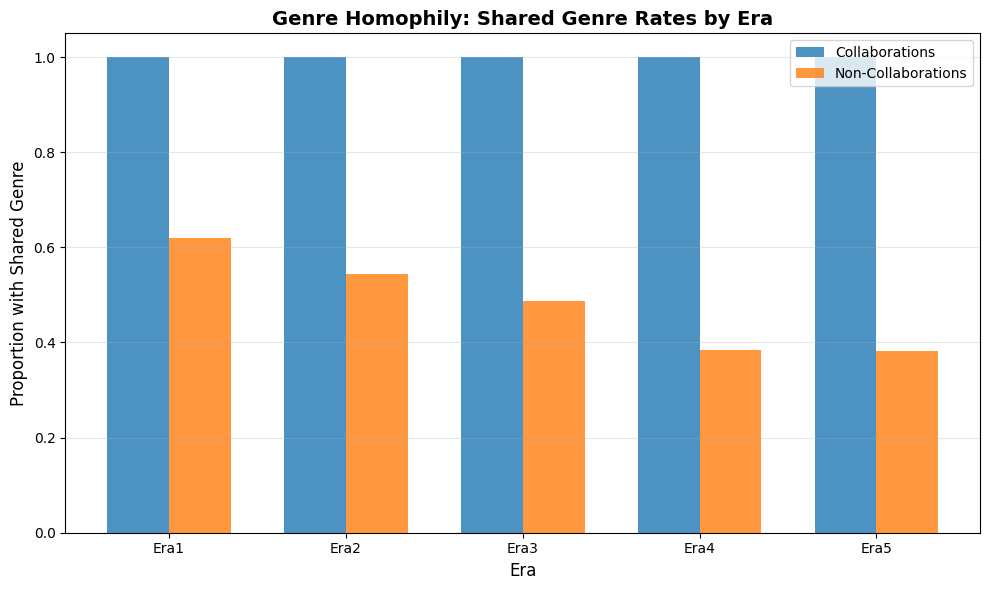

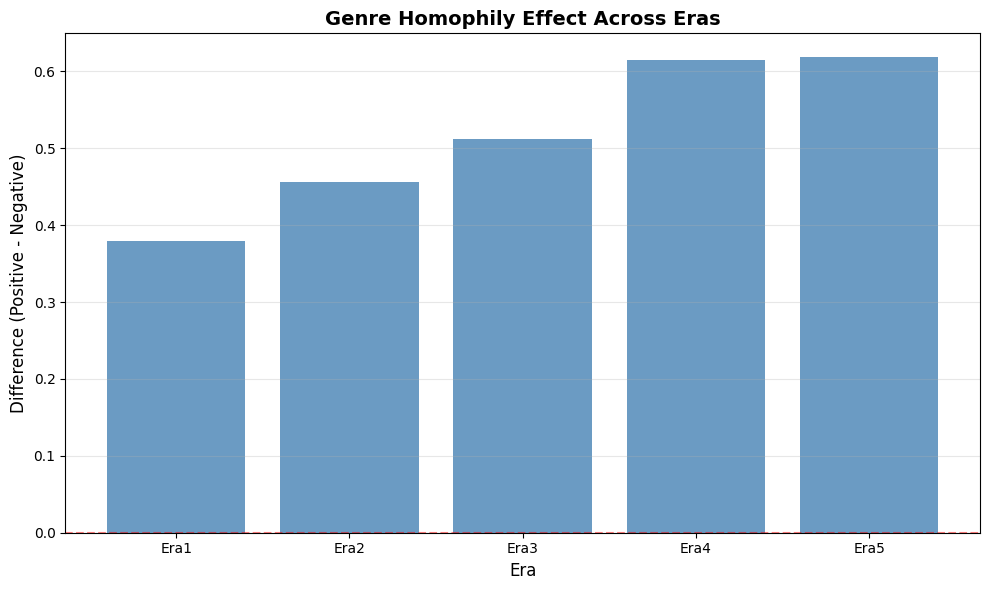

In [16]:
homophily_data = []

for era, genre_df in all_genre_results.items():
    pos_df = genre_df[genre_df['label'] == 1]
    neg_df = genre_df[genre_df['label'] == 0]
    
    pos_rate = (pos_df['same_genre'] == 1).mean()
    neg_rate = (neg_df['same_genre'] == 1).mean()
    difference = pos_rate - neg_rate
    
    homophily_data.append({
        'era': era,
        'Collaborations': pos_rate,
        'Non-Collaborations': neg_rate,
        'Difference': difference
    })

homophily_df = pd.DataFrame(homophily_data)
print(homophily_df)

# Plot 1: same-genre
plt.figure(figsize=(10, 6))
x = np.arange(len(homophily_df))
width = 0.35

plt.bar(x - width/2, homophily_df['Collaborations'], width, label='Collaborations', alpha=0.8)
plt.bar(x + width/2, homophily_df['Non-Collaborations'], width, label='Non-Collaborations', alpha=0.8)

plt.xlabel('Era', fontsize=12)
plt.ylabel('Proportion with Shared Genre', fontsize=12)
plt.title('Genre Homophily: Shared Genre Rates by Era', fontsize=14, fontweight='bold')
plt.xticks(x, homophily_df['era'])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: diff between pos and neg
plt.figure(figsize=(10, 6))
plt.bar(homophily_df['era'], homophily_df['Difference'], color='steelblue', alpha=0.8)
plt.xlabel('Era', fontsize=12)
plt.ylabel('Difference (Positive - Negative)', fontsize=12)
plt.title('Genre Homophily Effect Across Eras', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Detailed Metric Evaluation

Beyond AUC, we'll compute comprehensive evaluation metrics for each genre-based feature:
- **AUC**
- **Precision**
- **Recall**
- **Hits@K**
- **Score Distributions**

In [17]:
def normalizeCol(df, col):
    min_val = df[col].min()
    max_val = df[col].max()
    if max_val - min_val > 0:
        return (df[col] - min_val) / (max_val - min_val)
    else:
        return df[col]

def evaluate(df, graphMetric, threshold=0.5):
    df = df.copy()
    df['score_normalized'] = normalizeCol(df, graphMetric)
    
    if df['score_normalized'].nunique() <= 1:
        print(f"\n{graphMetric.upper()}: skipping")
        return None
    
    # AUC
    auc = roc_auc_score(df['label'], df['score_normalized'])
    
    # Precision and Recall 
    df['pred'] = (df['score_normalized'] >= threshold).astype(int)
    precision = precision_score(df['label'], df['pred'], zero_division=0)
    recall = recall_score(df['label'], df['pred'], zero_division=0)
    
    # Hits@K (top 1000 predictions)
    K = min(1000, len(df))
    top_k_indices = df.nlargest(K, 'score_normalized').index
    hits_at_k = df.loc[top_k_indices, 'label'].sum()
    
    print(f"\n{graphMetric.upper()} Evaluation:")
    print(f"AUC: {auc:.4f}")
    print(f"Precision@{threshold}: {precision:.4f}")
    print(f"Recall@{threshold}: {recall:.4f}")
    print(f"Hits@{K}: {hits_at_k}")
    
    # Plot score distributions
    pos_scores = df[df['label'] == 1]['score_normalized']
    neg_scores = df[df['label'] == 0]['score_normalized']
    
    plt.figure(figsize=(10, 6))
    plt.hist(pos_scores, bins=30, alpha=0.6, label='Collaborations', color='green', edgecolor='black')
    plt.hist(neg_scores, bins=30, alpha=0.6, label='Non-Collaborations', color='red', edgecolor='black')
    plt.axvline(x=threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold={threshold}')
    plt.xlabel('Normalized Score', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'{graphMetric.upper()} Score Distribution', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'hits_at_k': hits_at_k
    }

## Evaluate Genre Features Across All Eras

Run comprehensive evaluation for all genre-based features across all 5 musical eras.


Evaluating Era1

GENRE_JACCARD Evaluation:
AUC: 0.8094
Precision@0.5: 0.7401
Recall@0.5: 0.6391
Hits@1000: 981


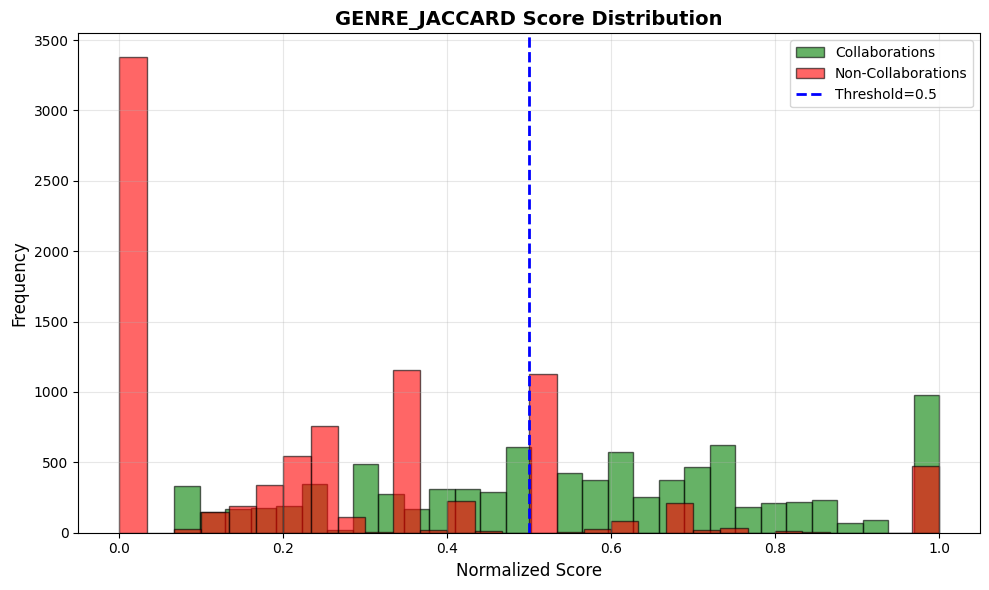


GENRE_OVERLAP Evaluation:
AUC: 0.9332
Precision@0.5: 0.9995
Recall@0.5: 0.2365
Hits@1000: 1000


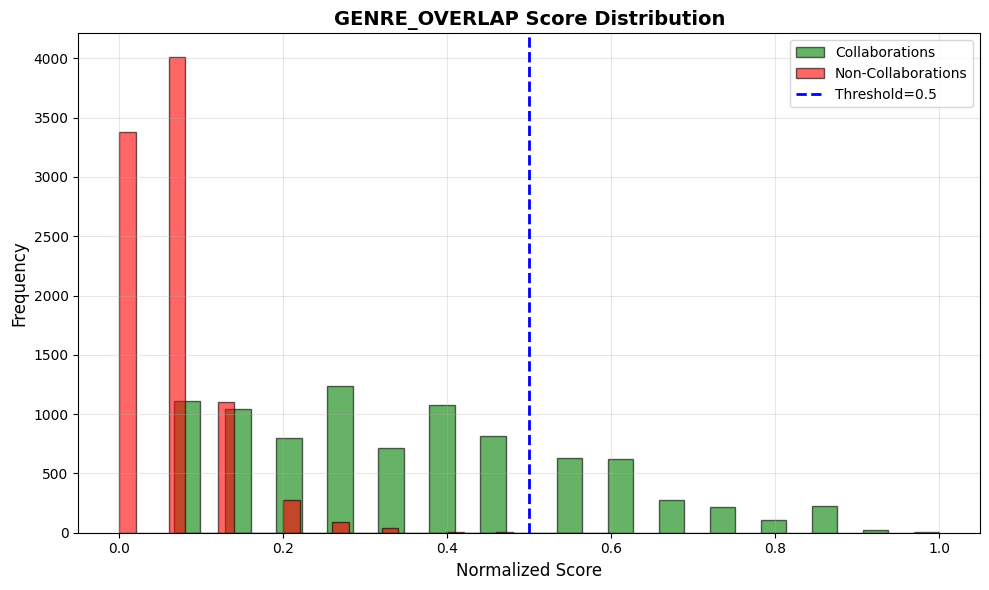


SAME_GENRE Evaluation:
AUC: 0.6897
Precision@0.5: 0.6171
Recall@0.5: 1.0000
Hits@1000: 1000


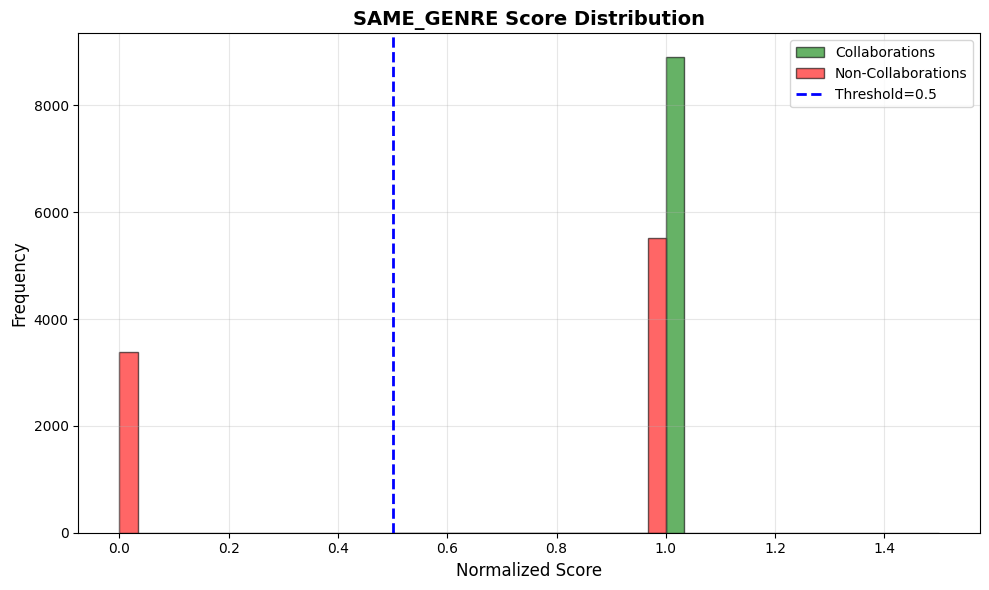


Evaluating Era2

GENRE_JACCARD Evaluation:
AUC: 0.8418
Precision@0.5: 0.8095
Recall@0.5: 0.5358
Hits@1000: 1000


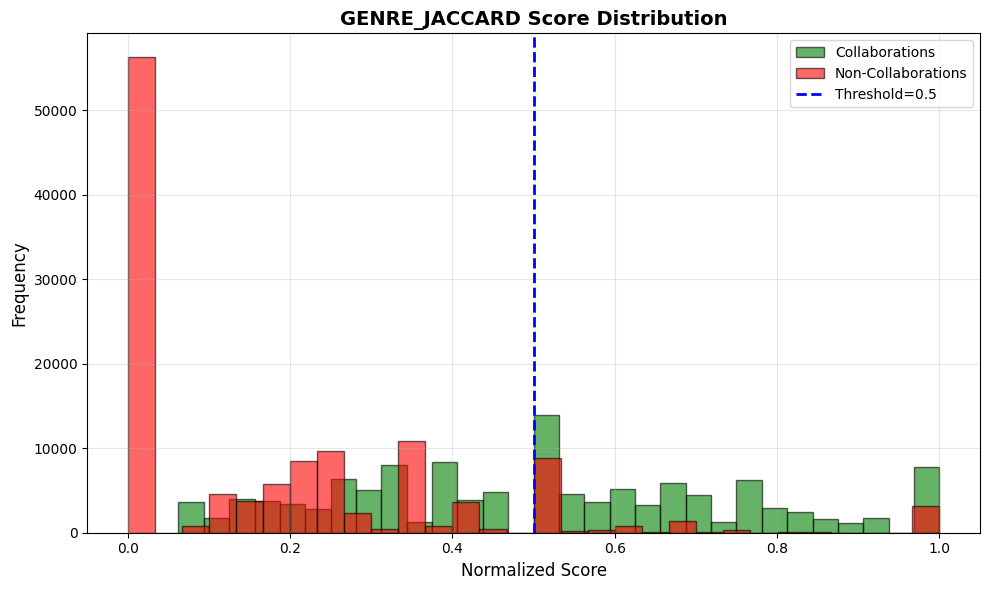


GENRE_OVERLAP Evaluation:
AUC: 0.9048
Precision@0.5: 0.9957
Recall@0.5: 0.1573
Hits@1000: 1000


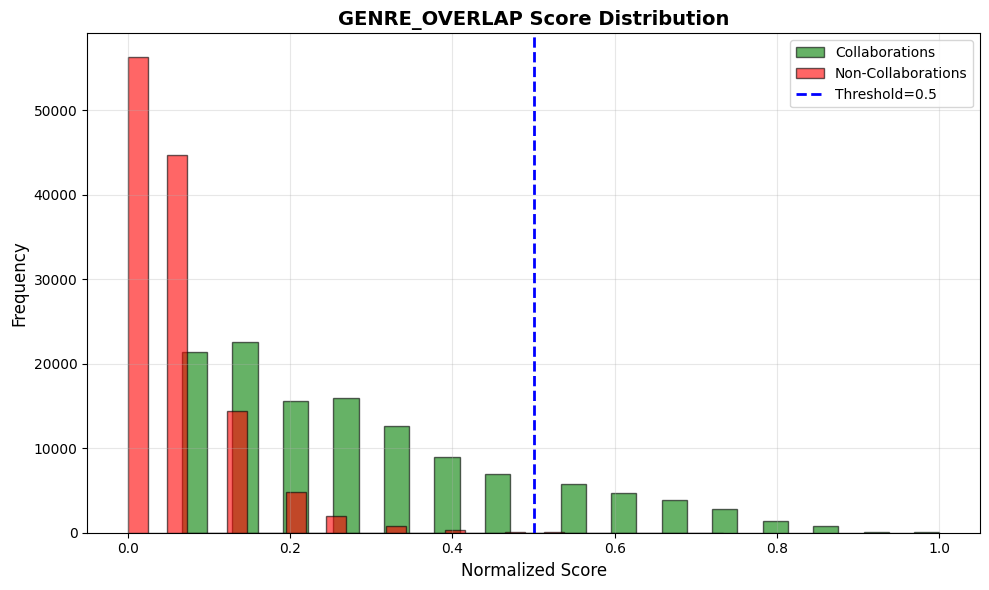


SAME_GENRE Evaluation:
AUC: 0.7279
Precision@0.5: 0.6476
Recall@0.5: 1.0000
Hits@1000: 1000


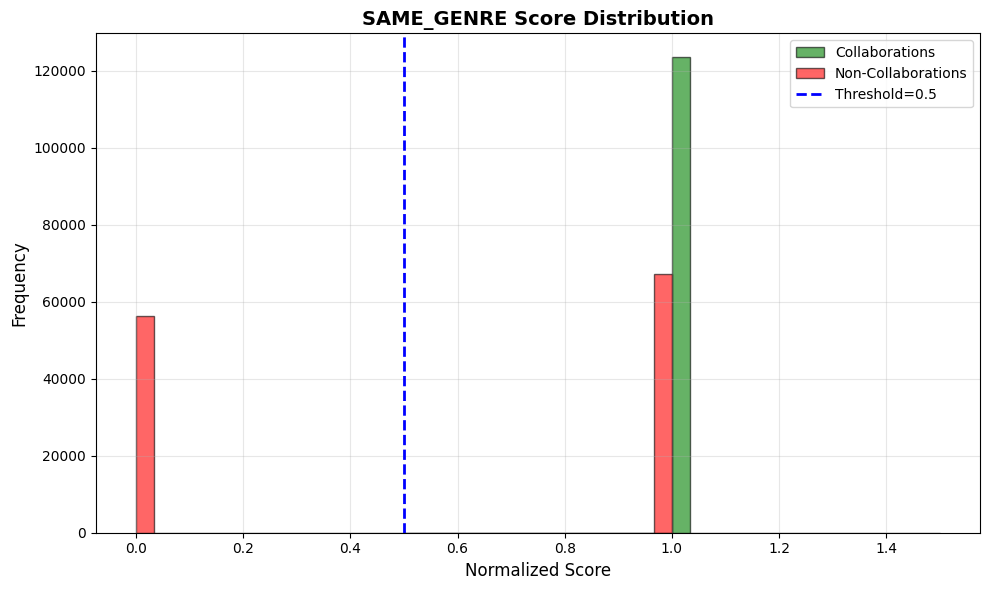


Evaluating Era3

GENRE_JACCARD Evaluation:
AUC: 0.8503
Precision@0.5: 0.8092
Recall@0.5: 0.5395
Hits@1000: 1000


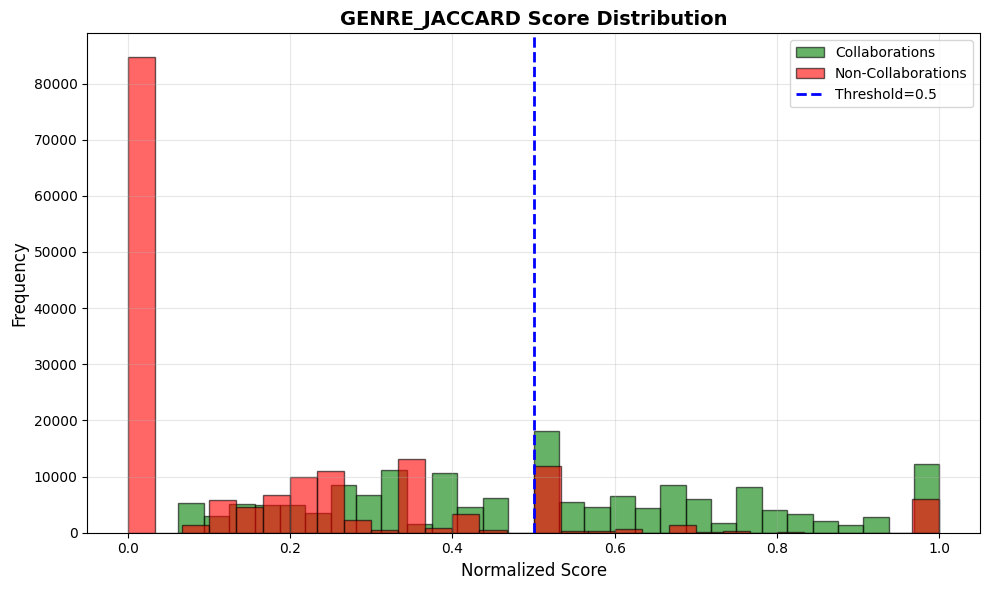


GENRE_OVERLAP Evaluation:
AUC: 0.9159
Precision@0.5: 0.9972
Recall@0.5: 0.1670
Hits@1000: 1000


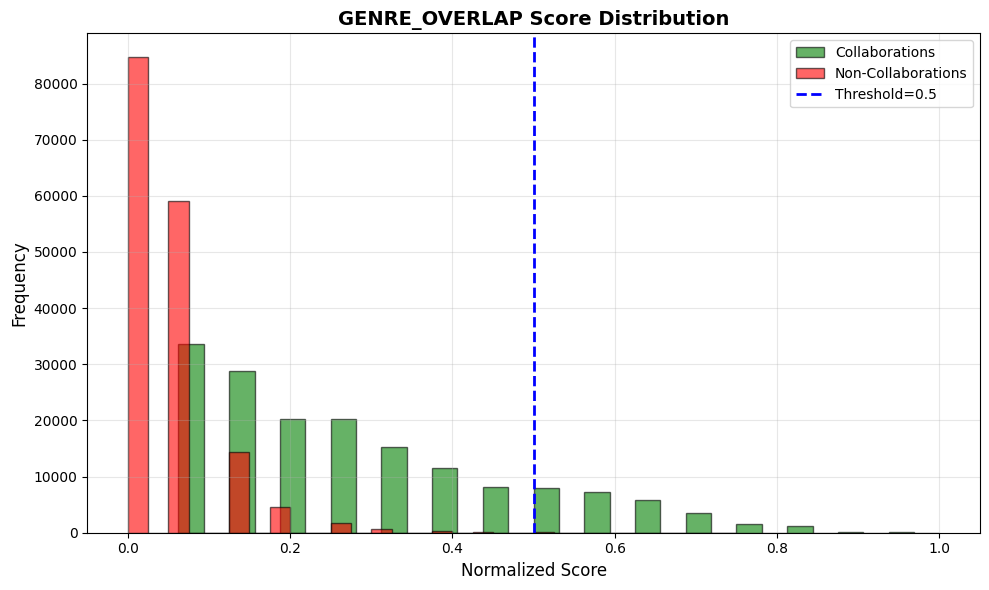


SAME_GENRE Evaluation:
AUC: 0.7559
Precision@0.5: 0.6719
Recall@0.5: 1.0000
Hits@1000: 1000


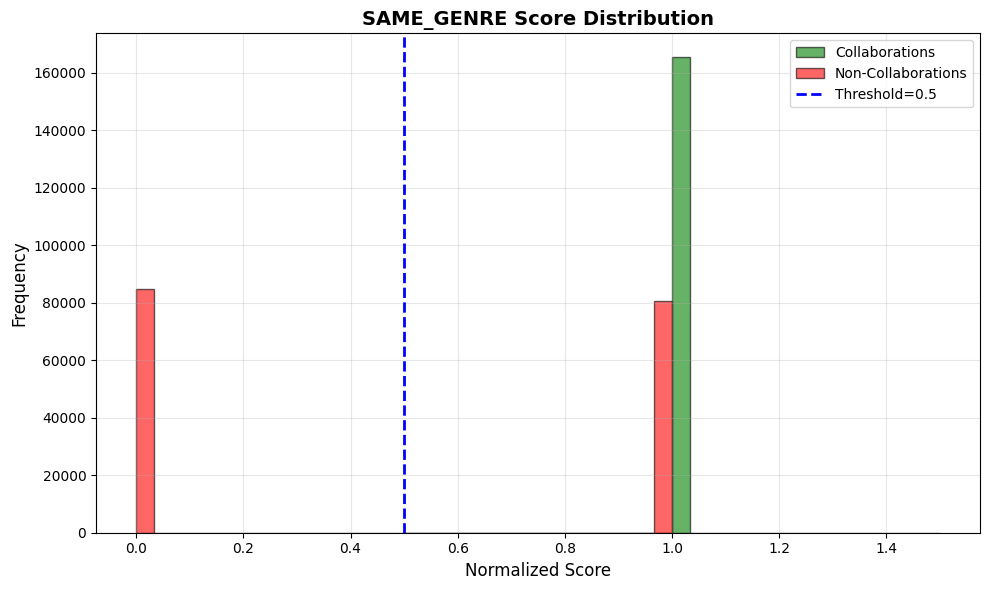


Evaluating Era4

GENRE_JACCARD Evaluation:
AUC: 0.8756
Precision@0.5: 0.8342
Recall@0.5: 0.5281
Hits@1000: 1000


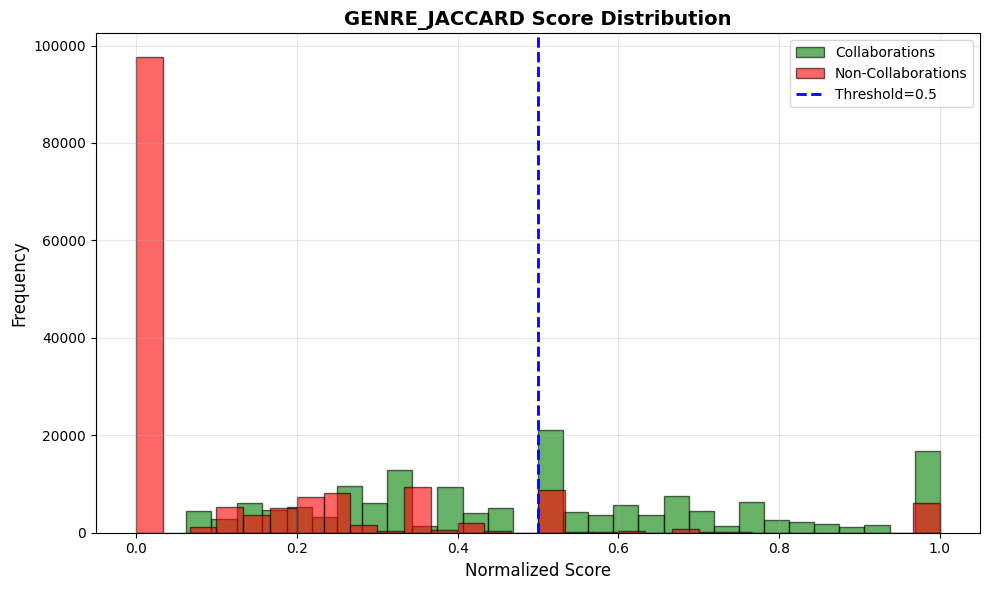


GENRE_OVERLAP Evaluation:
AUC: 0.9168
Precision@0.5: 0.9977
Recall@0.5: 0.1172
Hits@1000: 1000


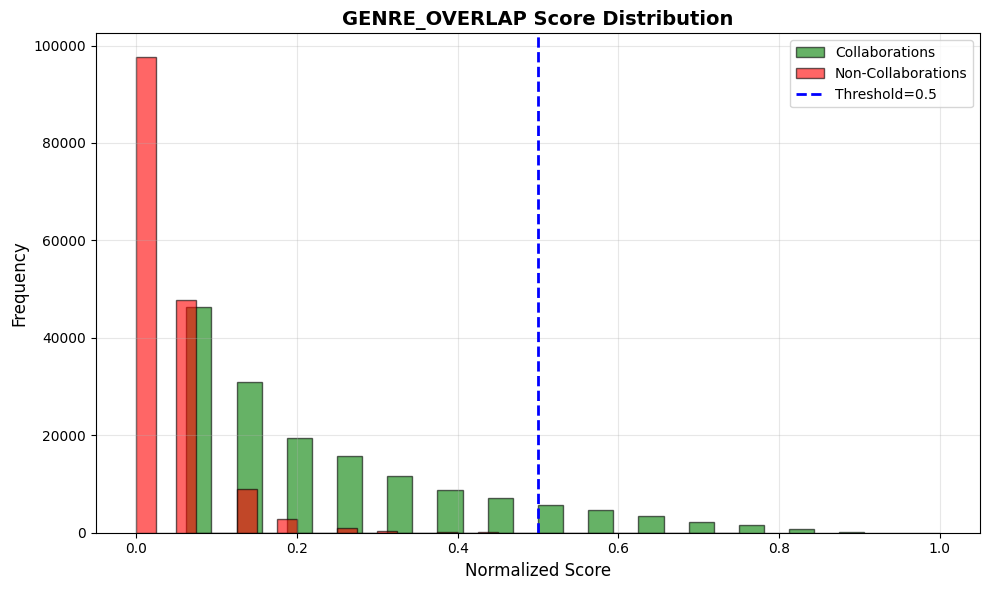


SAME_GENRE Evaluation:
AUC: 0.8074
Precision@0.5: 0.7219
Recall@0.5: 1.0000
Hits@1000: 1000


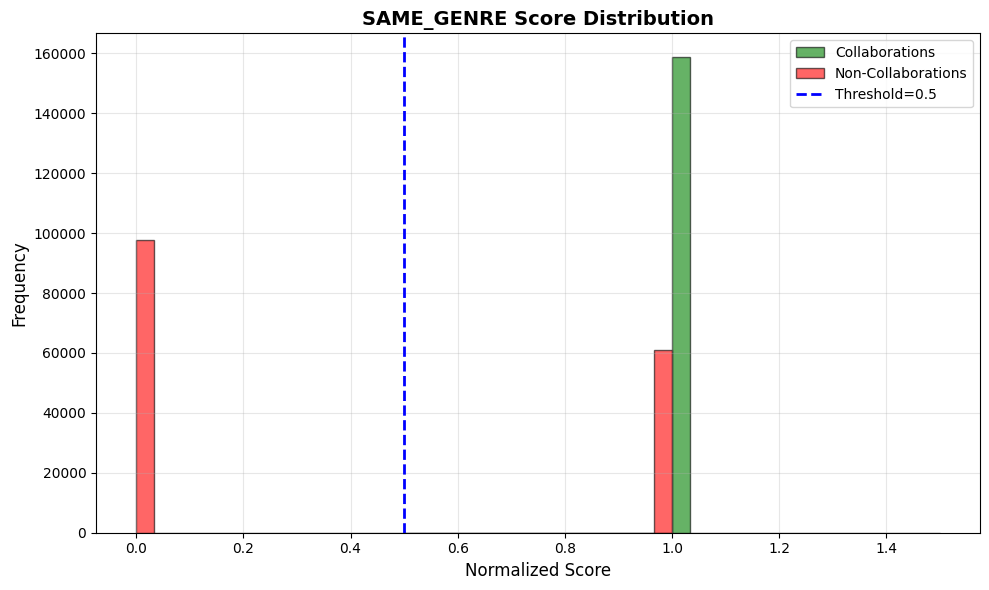


Evaluating Era5

GENRE_JACCARD Evaluation:
AUC: 0.8481
Precision@0.5: 0.7805
Recall@0.5: 0.6108
Hits@1000: 1000


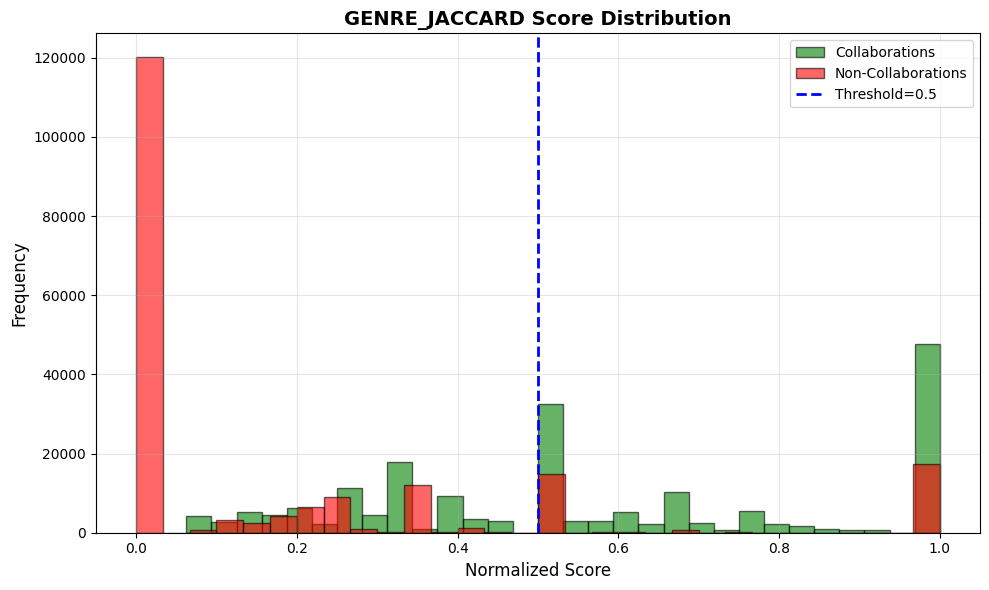


GENRE_OVERLAP Evaluation:
AUC: 0.8917
Precision@0.5: 0.9989
Recall@0.5: 0.0435
Hits@1000: 1000


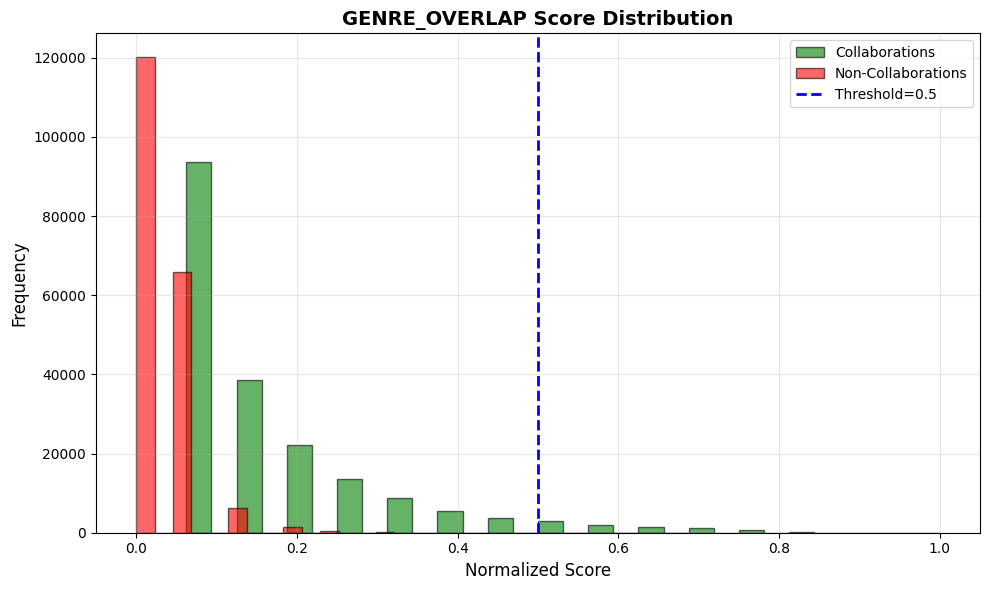


SAME_GENRE Evaluation:
AUC: 0.8094
Precision@0.5: 0.7240
Recall@0.5: 1.0000
Hits@1000: 1000


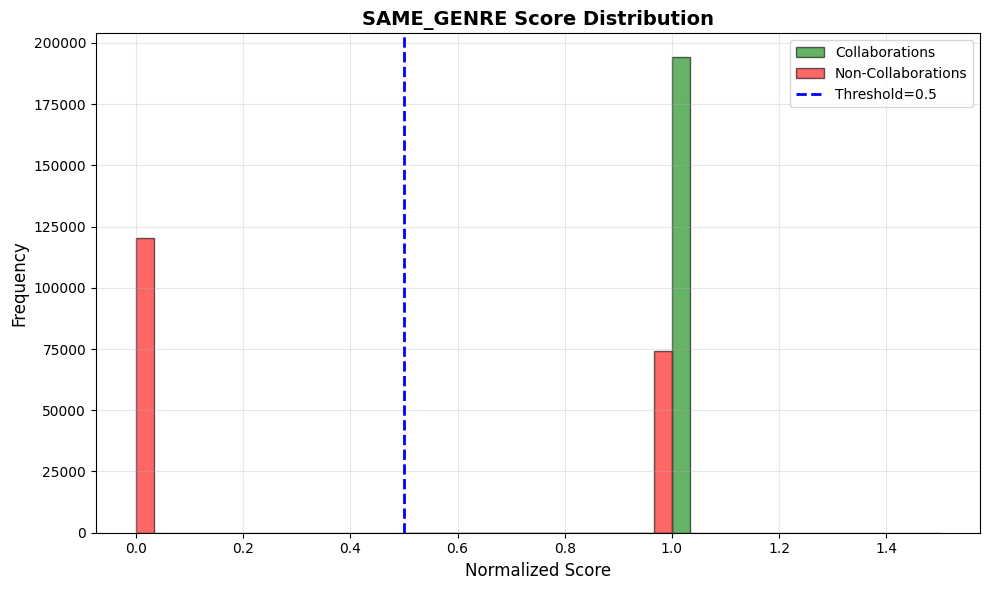



Summary of Genre Feature Evaluation:
 era        metric      auc  precision   recall  hits_at_k
Era1 genre_jaccard 0.809404   0.740052 0.639079        981
Era1 genre_overlap 0.933156   0.999525 0.236496       1000
Era1    same_genre 0.689725   0.617074 1.000000       1000
Era2 genre_jaccard 0.841812   0.809533 0.535818       1000
Era2 genre_overlap 0.904790   0.995694 0.157251       1000
Era2    same_genre 0.727886   0.647573 1.000000       1000
Era3 genre_jaccard 0.850348   0.809169 0.539495       1000
Era3 genre_overlap 0.915909   0.997185 0.166951       1000
Era3    same_genre 0.755882   0.671936 1.000000       1000
Era4 genre_jaccard 0.875648   0.834234 0.528121       1000
Era4 genre_overlap 0.916763   0.997748 0.117215       1000
Era4    same_genre 0.807417   0.721936 1.000000       1000
Era5 genre_jaccard 0.848075   0.780471 0.610807       1000
Era5 genre_overlap 0.891722   0.998936 0.043515       1000
Era5    same_genre 0.809353   0.723959 1.000000       1000


In [18]:
genre_eval_results = []

for era, genre_df in all_genre_results.items():
    print(f"\n{'='*60}")
    print(f"Evaluating {era}")
    print('='*60)
    
    for metric in ['genre_jaccard', 'genre_overlap', 'same_genre']:
        result = evaluate(genre_df, metric, threshold=0.5)
        if result:
            genre_eval_results.append({
                'era': era,
                'metric': metric,
                **result
            })
            
#print out a summary
genre_eval_df = pd.DataFrame(genre_eval_results)
print("\n\nSummary of Genre Feature Evaluation:")
print(genre_eval_df.to_string(index=False))

## Combined Evaluation Visualization

Create separate plots comparing all genre features across eras for each metric type.

<Figure size 1200x600 with 0 Axes>

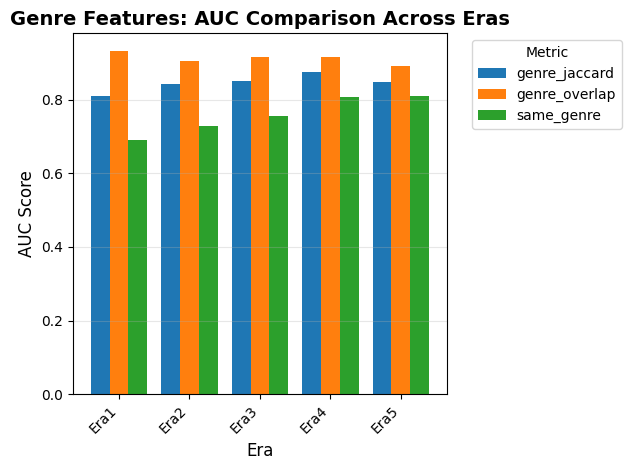

<Figure size 1200x600 with 0 Axes>

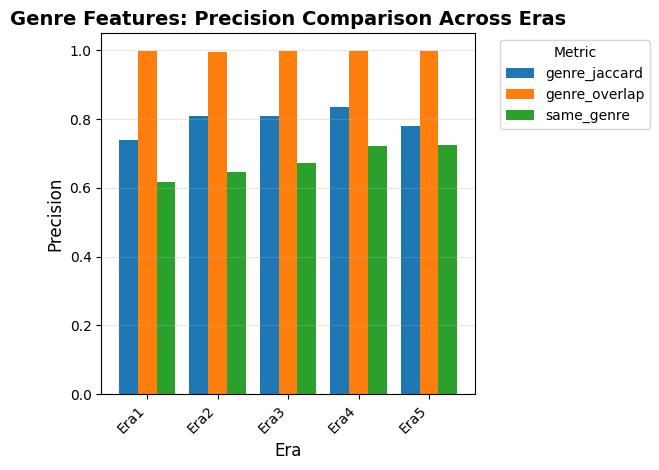

<Figure size 1200x600 with 0 Axes>

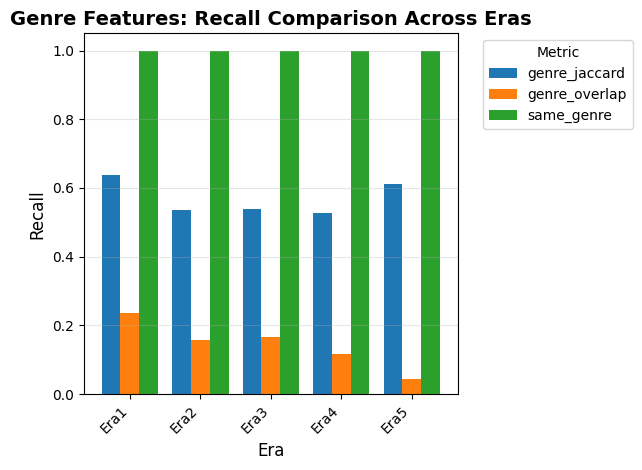

<Figure size 1200x600 with 0 Axes>

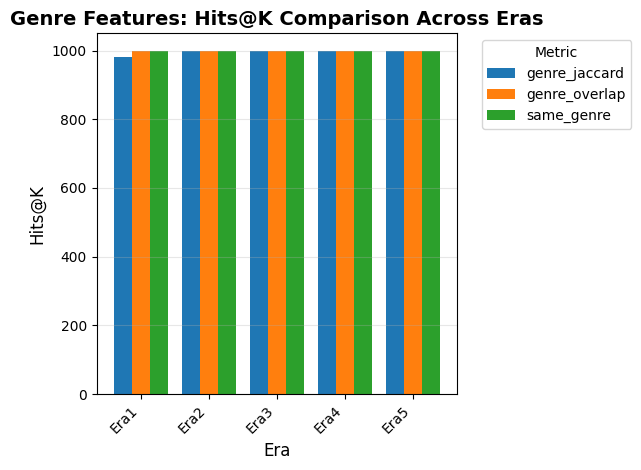

In [19]:
# 1. AUC Comparison
plt.figure(figsize=(12, 6))
pivot_auc = genre_eval_df.pivot(index='era', columns='metric', values='auc')
pivot_auc.plot(kind='bar', width=0.8)
plt.title('Genre Features: AUC Comparison Across Eras', fontsize=14, fontweight='bold')
plt.xlabel('Era', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Precision Comparison
plt.figure(figsize=(12, 6))
pivot_precision = genre_eval_df.pivot(index='era', columns='metric', values='precision')
pivot_precision.plot(kind='bar', width=0.8)
plt.title('Genre Features: Precision Comparison Across Eras', fontsize=14, fontweight='bold')
plt.xlabel('Era', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Recall Comparison
plt.figure(figsize=(12, 6))
pivot_recall = genre_eval_df.pivot(index='era', columns='metric', values='recall')
pivot_recall.plot(kind='bar', width=0.8)
plt.title('Genre Features: Recall Comparison Across Eras', fontsize=14, fontweight='bold')
plt.xlabel('Era', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Hits@K Comparison
plt.figure(figsize=(12, 6))
pivot_hits = genre_eval_df.pivot(index='era', columns='metric', values='hits_at_k')
pivot_hits.plot(kind='bar', width=0.8)
plt.title('Genre Features: Hits@K Comparison Across Eras', fontsize=14, fontweight='bold')
plt.xlabel('Era', fontsize=12)
plt.ylabel('Hits@K', fontsize=12)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()